# Compare heldout performance on predicting age and pseudo-age

- Need to hold out age
- minmax normalize chronological age
- also try binning pseudo age

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_predict, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from aging.plotting import format_plots, figure, save_factory, PlotConfig, ONTOGENY_AGE_CMAP

In [14]:
format_plots()
c = PlotConfig()
saver = save_factory(c.dana_save_path / "pseudotime", tight_layout=False)

In [15]:
df = pd.read_parquet(
    "/n/groups/datta/win/longtogeny/data/ontogeny/version_07/ontogeny_males_clean_pseudotime_v02.parquet"
)
df = df.dropna(subset=["pseudotime_rank"])
pseudo_cuts = pd.qcut(
    df["pseudotime_rank"], df.index.get_level_values("age").nunique(), labels=False
)
enc = LabelEncoder().fit(df.index.get_level_values("age"))
age_cuts = enc.transform(df.index.get_level_values("age"))
pseudo_mapped = enc.inverse_transform(pseudo_cuts)

In [16]:
def run_model(model_type="pls", y_var="true_age"):
    if model_type == "pls":
        mdl = PLSRegression(n_components=3)
    elif model_type == "knn":
        mdl = KNeighborsRegressor(n_neighbors=6)

    if y_var == "true_age":
        y = np.log(df.index.get_level_values("age"))
        #y = df.index.get_level_values("age")
        groups = df.index.get_level_values("age")
    elif y_var == "pseudo_age":
        y= np.log(pseudo_mapped)
        #y = pseudo_mapped
        groups = pseudo_cuts

    pipeline = make_pipeline(StandardScaler(), mdl)

    age_hat = cross_val_predict(
        pipeline,
        X=df.filter(regex=r"\d"),
        y=y,
        groups=groups,
        cv=LeaveOneGroupOut(),
        n_jobs=-1,
    )

    r2 = r2_score(y, age_hat.squeeze())
    return pipeline, age_hat.squeeze(), y, r2

In [17]:
pipeline, age_hat, age, r2 = run_model("pls", "true_age")

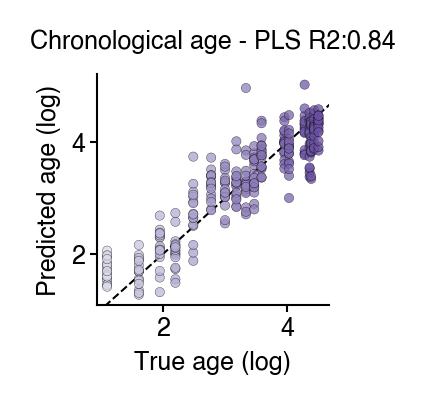

In [18]:
fig = figure(1, 1)
plt.scatter(age, age_hat, s=5, alpha=0.75, lw=0.1, ec='k', cmap=ONTOGENY_AGE_CMAP, c=age)
plt.xlabel("True age (log)")
plt.ylabel("Predicted age (log)")
plt.title(f"Chronological age - PLS R2:{r2:0.2f}")
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([0, 6], [0, 6], ls='--', c='k', lw=0.5, zorder=-1)
plt.xlim(xlim)
plt.ylim(ylim)
sns.despine()
saver(fig, "pls-held-out-r2-true-age");

In [19]:
pipeline, age_hat, age, r2 = run_model("pls", "pseudo_age")

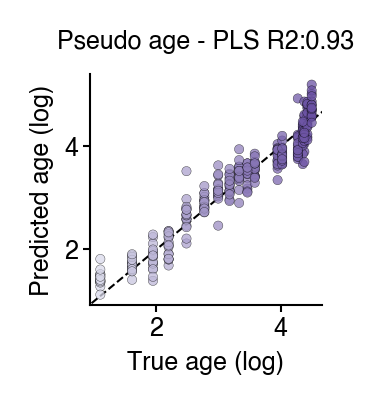

In [20]:
fig = figure(1, 1)
plt.scatter(age, age_hat, s=5, alpha=0.75, lw=0.1, ec='k', cmap=ONTOGENY_AGE_CMAP, c=age)
plt.xlabel("True age (log)")
plt.ylabel("Predicted age (log)")
plt.title(f"Pseudo age - PLS R2:{r2:0.2f}")
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([0, 6], [0, 6], ls='--', c='k', lw=0.5, zorder=-1)
plt.xlim(xlim)
plt.ylim(ylim)
sns.despine()
saver(fig, "pls-held-out-r2-pseudo-age");

In [21]:
pipeline, age_hat, age, r2 = run_model("knn", "true_age")

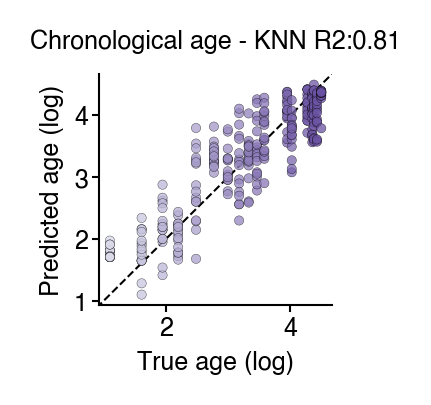

In [22]:
fig = figure(1, 1)
plt.scatter(age, age_hat, s=5, alpha=0.75, lw=0.1, ec='k', cmap=ONTOGENY_AGE_CMAP, c=age)
plt.xlabel("True age (log)")
plt.ylabel("Predicted age (log)")
plt.title(f"Chronological age - KNN R2:{r2:0.2f}")
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([0, 6], [0, 6], ls='--', c='k', lw=0.5, zorder=-1)
plt.xlim(xlim)
plt.ylim(ylim)
sns.despine()
saver(fig, "knn-held-out-r2-true-age");

In [23]:
pipeline, age_hat, age, r2 = run_model("knn", "pseudo_age")

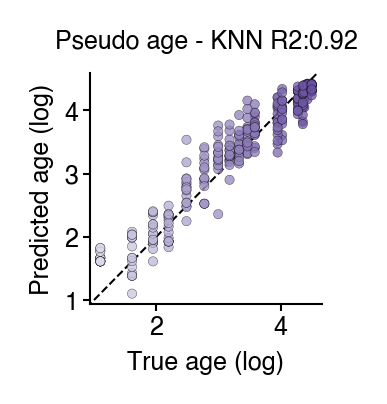

In [24]:
fig = figure(1, 1)
plt.scatter(age, age_hat, s=5, alpha=0.75, lw=0.1, ec='k', cmap=ONTOGENY_AGE_CMAP, c=age)
plt.xlabel("True age (log)")
plt.ylabel("Predicted age (log)")
plt.title(f"Pseudo age - KNN R2:{r2:0.2f}")
xlim, ylim = plt.xlim(), plt.ylim()
plt.plot([0, 6], [0, 6], ls='--', c='k', lw=0.5, zorder=-1)
plt.xlim(xlim)
plt.ylim(ylim)
sns.despine()
saver(fig, "knn-held-out-r2-pseudo-age");